## Import Required Library

In [1]:
import numpy as np
import torch
import math
from torch import nn
import torch.nn.functional as F
#device = ("cuda" if torch.cuda.is_available() else "cpu")

## Model Definition

In [2]:
# Dense Net
# Bottle Neck

class BottleNeck(nn.Module):
    def __init__(self,num_channels,growth_rate,bn_size,drop_rate):
        super(BottleNeck ,self).__init__()
        mid_channel = int(bn_size*growth_rate)
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.conv1 = nn.Conv2d(num_channels,mid_channel ,kernel_size=1 , bias=False)
        self.bn2 = nn.BatchNorm2d(mid_channel)
        self.conv2 = nn.Conv2d(mid_channel ,growth_rate , kernel_size=3 , bias=False,padding=1)
        self.drop_rate=drop_rate
    
    def forward(self,x):
        new_features = self.conv1(F.leaky_relu(self.bn1(x)))
        new_features = self.conv2(F.leaky_relu(self.bn2(new_features)))
        if self.drop_rate > 0:
            new_features = F.dropout(new_features, p=self.drop_rate, training=self.training)
        return(torch.cat([x,new_features],1))

#### Transition

In [3]:
class Transition(nn.Module):
    def __init__(self, num_channels, num_out_channels):
        super(Transition, self).__init__()
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.conv1 = nn.Conv2d(num_channels, num_out_channels, kernel_size=1,
                               bias=False)

    def forward(self, x):
        out = self.conv1(F.leaky_relu(self.bn1(x)))
        out = F.avg_pool2d(out, 2)
        return out

In [4]:
(50-3)//3

15

#### Artitechture

In [5]:
class DenseNet(nn.Module):
  
    def __init__(self, growth_rate, depth, reduction , num_classes,bn_size=4,drop_rate=0.15):
        super(DenseNet , self).__init__()

        no_of_dense_blocks = (depth-4)//6 #16
        num_channels = 2*growth_rate #24

        self.conv1 = nn.Conv2d(3,num_channels , kernel_size=3 ,padding=1,bias=False) #first conv layer

        self.dense_block1 = self._gen_dense_block(num_channels , growth_rate, no_of_dense_blocks,bn_size,drop_rate) # first dense block
        num_channels += no_of_dense_blocks * growth_rate
        num_out_channels = int(math.floor(num_channels*reduction))
        self.trans_block1 = Transition(num_channels , num_out_channels) #first transition block

        num_channels = num_out_channels
        self.dense_block2 = self._gen_dense_block(num_channels , growth_rate, no_of_dense_blocks,bn_size,drop_rate) # second dense block
        num_channels += no_of_dense_blocks * growth_rate
        num_out_channels = int(math.floor(num_channels*reduction))
        self.trans_block2 = Transition(num_channels , num_out_channels) #first transition block

        num_channels = num_out_channels
        self.dense_block3 = self._gen_dense_block(num_channels , growth_rate, no_of_dense_blocks,bn_size,drop_rate) #third Dense block
        num_channels += no_of_dense_blocks * growth_rate

        self.bn1 = nn.BatchNorm2d(num_channels) # final batch norm
        self.pool = nn.AvgPool2d(kernel_size=8, stride=1, padding=0)

        ## classifier
        self.classifier = self.create_head(num_channels , num_classes)

        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.constant_(m.bias, 0)
                
    def _gen_dense_block(self,num_channels , growth_rate, no_of_dense_blocks,bn_size,drop_rate):
        return nn.Sequential(*[ BottleNeck(int(num_channels+i*growth_rate) , growth_rate,bn_size,drop_rate) for i in range(no_of_dense_blocks)]) 
  
    def create_head(self,num_features , number_classes ,dropout_prob=0.15 ,activation_func =nn.LeakyReLU):
        features_lst = [num_features , num_features//2 , num_features//4]
        layers = []
        for in_f ,out_f in zip(features_lst[:-1] , features_lst[1:]):
            layers.append(nn.Linear(in_f , out_f))
            layers.append(activation_func())
            layers.append(nn.BatchNorm1d(out_f))
            if dropout_prob !=0 : layers.append(nn.Dropout(dropout_prob))
        layers.append(nn.Linear(features_lst[-1] , number_classes))
        return nn.Sequential(*layers)

    def forward(self,x):
        x = self.conv1(x)
        x = self.trans_block1(self.dense_block1(x))
        x = self.trans_block2(self.dense_block2(x))
        x = self.pool(F.leaky_relu(self.bn1(self.dense_block3(x))))
        x = x.view(x.size(0) , -1)
        x = self.classifier(x)
        return x

## Save Model

In [7]:
path = r'C:\Users\91892\Documents\Python_jupyter\Deep Learning\Assignment\Densenet'

In [8]:
the_model = torch.load(path+'\CIFAR10_v3.pt', map_location='cpu')

### Inference

In [13]:
def Infer(model, image_input):
    import torch
    classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship','truck']
    
    #model = model.to(device)
    model.eval()
    out = model(image_input)#.squeeze(0)
    prob = torch.argmax(out).item()
    #print(prob)
    return(classes[prob])

In [14]:
def input_image(path):
    #from pathlib import Path
    from PIL import Image
    import torch
    from torchvision import  transforms
    size = 32,32
    img = Image.open(path)
    img.thumbnail(size, Image.ANTIALIAS)
    img = transforms.ToTensor()(img).unsqueeze(0)
    #img = img.to(device)
    return(img)

In [15]:
inp = input_image('cat.jpg')

In [16]:
inp1 = input_image('truck.jpg')

In [17]:
Infer(the_model, inp)

'cat'

In [20]:
from PIL import Image

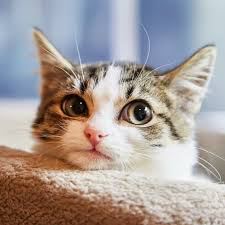

In [25]:
Image.open('cat.jpg', )